In [1]:
path_datos = "gs://bucket-tfm-llc/datos"

# Librerias

In [2]:
import pyspark.sql.functions as F

import seaborn as sns
import matplotlib.pyplot as plt
import math

# Lectura tablas

In [3]:
fec_inicio = "2019-01-01"
fec_fin = "2025-01-01"

output_name = "datos_noticias_cleaned_19_25"

In [4]:
datos_noticias = spark.read.parquet(f"{path_datos}/datos_noticias_19_24_trat").\
                          filter(F.col("date") >= fec_inicio).filter(F.col("date") < fec_fin)

# Funciones

In [5]:
def plot_boxplots(df_input, list_vars, var_target = "target", n_cols = 6):
  df = df_input.toPandas()
  n_vars = len(list_vars)
  rows = math.ceil(n_vars / n_cols)

  fig, axs = plt.subplots(nrows= rows, ncols= n_cols, figsize=(n_cols * 4, rows * 4))
  axs = axs.flatten()

  for i, var in enumerate(list_vars):
      sns.boxplot(x=df[var_target], y=df[var], ax=axs[i], color = "lightblue")
      axs[i].set_title(var)

  # Quitar ejes vacíos si sobran
  for j in range(i + 1, len(axs)):
      fig.delaxes(axs[j])

  plt.tight_layout()
  plt.show()

In [6]:
def num_outliers_IQR(df, list_vars, threshold=3):
  outliers_info = []

  for var in list_vars:
      q1, q3 = df.approxQuantile(var, [0.25, 0.75], 0.01)
      iqr = q3 - q1
      lower = q1 - threshold * iqr
      upper = q3 + threshold * iqr

      total = df.count()
      outliers_count = df.filter((F.col(var) < lower) | (F.col(var) > upper)).count()
      outlier_pct = 100 * (outliers_count / total)

      outliers_info.append({
          'feature': var,
          'outliers': outliers_count,
          'percent': outlier_pct,
          'lower_bound': lower,
          'upper_bound': upper
      })
  return spark.createDataFrame(outliers_info)

In [7]:
def wins_out_IQR(df, list_vars, threshold=3):
  df_out = df
  for var in list_vars:
    q1, q3 = df.approxQuantile(var, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower = q1 - threshold * iqr
    upper = q3 + threshold * iqr

    # df_out = df_filtrado.filter((F.col(var)>= lower) & (F.col(var) <= upper))
    df_out = df_out.withColumn(var, F.when(F.col(var) < lower, lower).when(F.col(var) > upper, upper).otherwise(F.col(var)))

  return df_out

# EDA

In [8]:
datos_noticias.count()

1510

In [9]:
datos_noticias.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- target: integer (nullable = true)
 |-- num_noticias_total: long (nullable = true)
 |-- avg_polaridad: double (nullable = true)
 |-- avg_pos_v2: double (nullable = true)
 |-- avg_neg_v2: double (nullable = true)
 |-- avg_pos_fb: double (nullable = true)
 |-- avg_neg_fb: double (nullable = true)
 |-- avg_neu_fb: double (nullable = true)
 |-- sent_neto_v2: double (nullable = true)
 |-- sent_neto_fb: double (nullable = true)
 |-- pct_pos_v2: double (nullable = true)
 |-- pct_neg_v2: double (nullable = true)
 |-- pct_neu_v2: double (nullable = true)
 |-- pct_pos_fb: double (nullable = true)
 |-- pct_neg_fb: double (nullable = true)
 |-- pct_neu_fb: double (nullable = true)
 |-- pct_sin_titulo: double (nullable = true)
 |-- ratio_pos_neg_v2: double (nullable = true)
 |-- ratio_pos_neg_fb: double (nullable = true)
 |-- diff_sent_fb_v2: double (nullable = true)
 |-- diff_pct_pos_fb_v2: double (nullable = true)
 |-- diff_pct_neg_fb_v2: double (nu

In [10]:
# Resumen estadístico:
# datos_noticias.summary().show()

In [11]:
# Valores nulos:
df_nulos = datos_noticias.select([F.sum(F.col(var).isNull().cast("int")).alias(var) for var in datos_noticias.columns])
nulos_row = df_nulos.collect()[0]

# Crear diccionario solo con columnas que tengan nulos
dict_vars_nulos = {col: nulos_row[col] for col in df_nulos.columns if nulos_row[col] > 0}
print(dict_vars_nulos)
    

25/06/21 09:06:44 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


{}


In [12]:
# # Eliminamos valores nulos: (Como no hay, no es necesario)
# datos_noticias = datos_noticias.dropna()
# datos_noticias.select([F.sum(F.col(var).isNull().cast("int")).alias(var) for var in datos_noticias.columns]).show()

## Target

In [13]:
datos_noticias.groupBy("target").agg(F.count("*").alias("num_casos")).show()

+------+---------+
|target|num_casos|
+------+---------+
|     1|      505|
|     0|     1005|
+------+---------+



In [14]:
for var in datos_noticias.columns:
    if var != "target" and datos_noticias.schema[var].dataType.simpleString() in ["double", "int", "bigint"]:
        corr = datos_noticias.stat.corr(var, "target")
        print(f"{var}: {corr}")

num_noticias_total: -0.03557352392039408
avg_polaridad: 0.028580868854067458
avg_pos_v2: 0.023906981333045
avg_neg_v2: 0.016429034897201916
avg_pos_fb: 0.029415825388653463
avg_neg_fb: 0.0012696083166094535
avg_neu_fb: 0.025397142012743356
sent_neto_v2: 0.007415213398843789
sent_neto_fb: 0.0207825582270327
pct_pos_v2: 0.018678950838459225
pct_neg_v2: -0.01795816645208593
pct_neu_v2: -0.023226321564363682
pct_pos_fb: 0.011800945357272184
pct_neg_fb: 0.009423872682459611
pct_neu_fb: 0.023180195325514418
pct_sin_titulo: -0.04416628436575441
ratio_pos_neg_v2: -0.013475087320802945
ratio_pos_neg_fb: -0.017849123623598216
diff_sent_fb_v2: -0.004480753537500921
diff_pct_pos_fb_v2: -0.009035404619848893
diff_pct_neg_fb_v2: 0.026150383353359355
delta_sent_neto_v2: 0.011062641340607545
delta_sent_neto_fb: 0.019349661700084005
delta_num_noticias: -0.02644760623766429
sent_neto_fb_mean_5d: -0.022378004173363202
sent_neto_v2_mean_5d: -0.027137346402010053
sent_neto_fb_std_5d: 0.021186108041193936
s

# Variables agregados diarios
Pulso informativo y el tono medio diario.

In [15]:
vars_general = ["num_noticias_total", "sent_neto_v2", "sent_neto_fb"]
vars_avg = ['avg_polaridad', 'avg_pos_v2', 'avg_neg_v2', 'avg_pos_fb', 'avg_neg_fb', 'avg_neu_fb']
vars_pct = [var for var in datos_noticias.columns if var.startswith("pct")]

vars_agregados = vars_general + vars_avg + vars_pct

In [16]:
datos_noticias.select(vars_agregados).summary().show()

+-------+------------------+--------------------+--------------------+------------------+------------------+------------------+--------------------+--------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+
|summary|num_noticias_total|        sent_neto_v2|        sent_neto_fb|     avg_polaridad|        avg_pos_v2|        avg_neg_v2|          avg_pos_fb|          avg_neg_fb|         avg_neu_fb|        pct_pos_v2|         pct_neg_v2|          pct_neu_v2|         pct_pos_fb|         pct_neg_fb|        pct_neu_fb|     pct_sin_titulo|
+-------+------------------+--------------------+--------------------+------------------+------------------+------------------+--------------------+--------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+------------------+-------------------+
|  count|    

In [17]:
# sns.pairplot(datos_noticias.toPandas()[vars_pct_noticias + ["target"]], corner=True, hue = "target", height = 1.8, aspect=1)
# plt.show()

<AxesSubplot:>

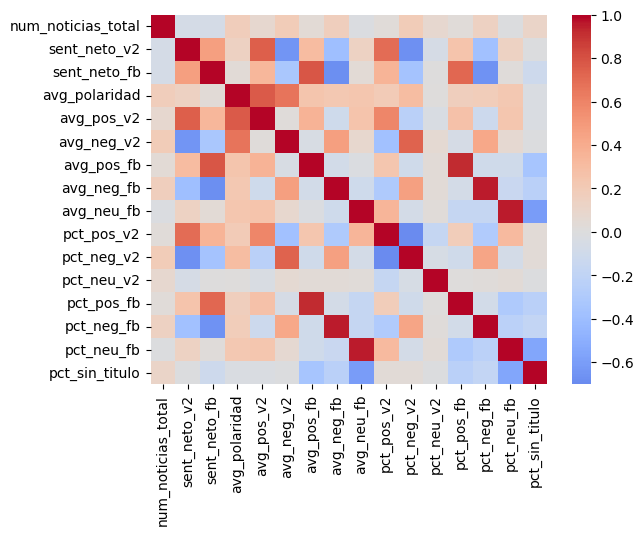

In [18]:
df_corr = datos_noticias.toPandas()
sns.heatmap(df_corr[vars_agregados].corr(), cmap="coolwarm", center=0)

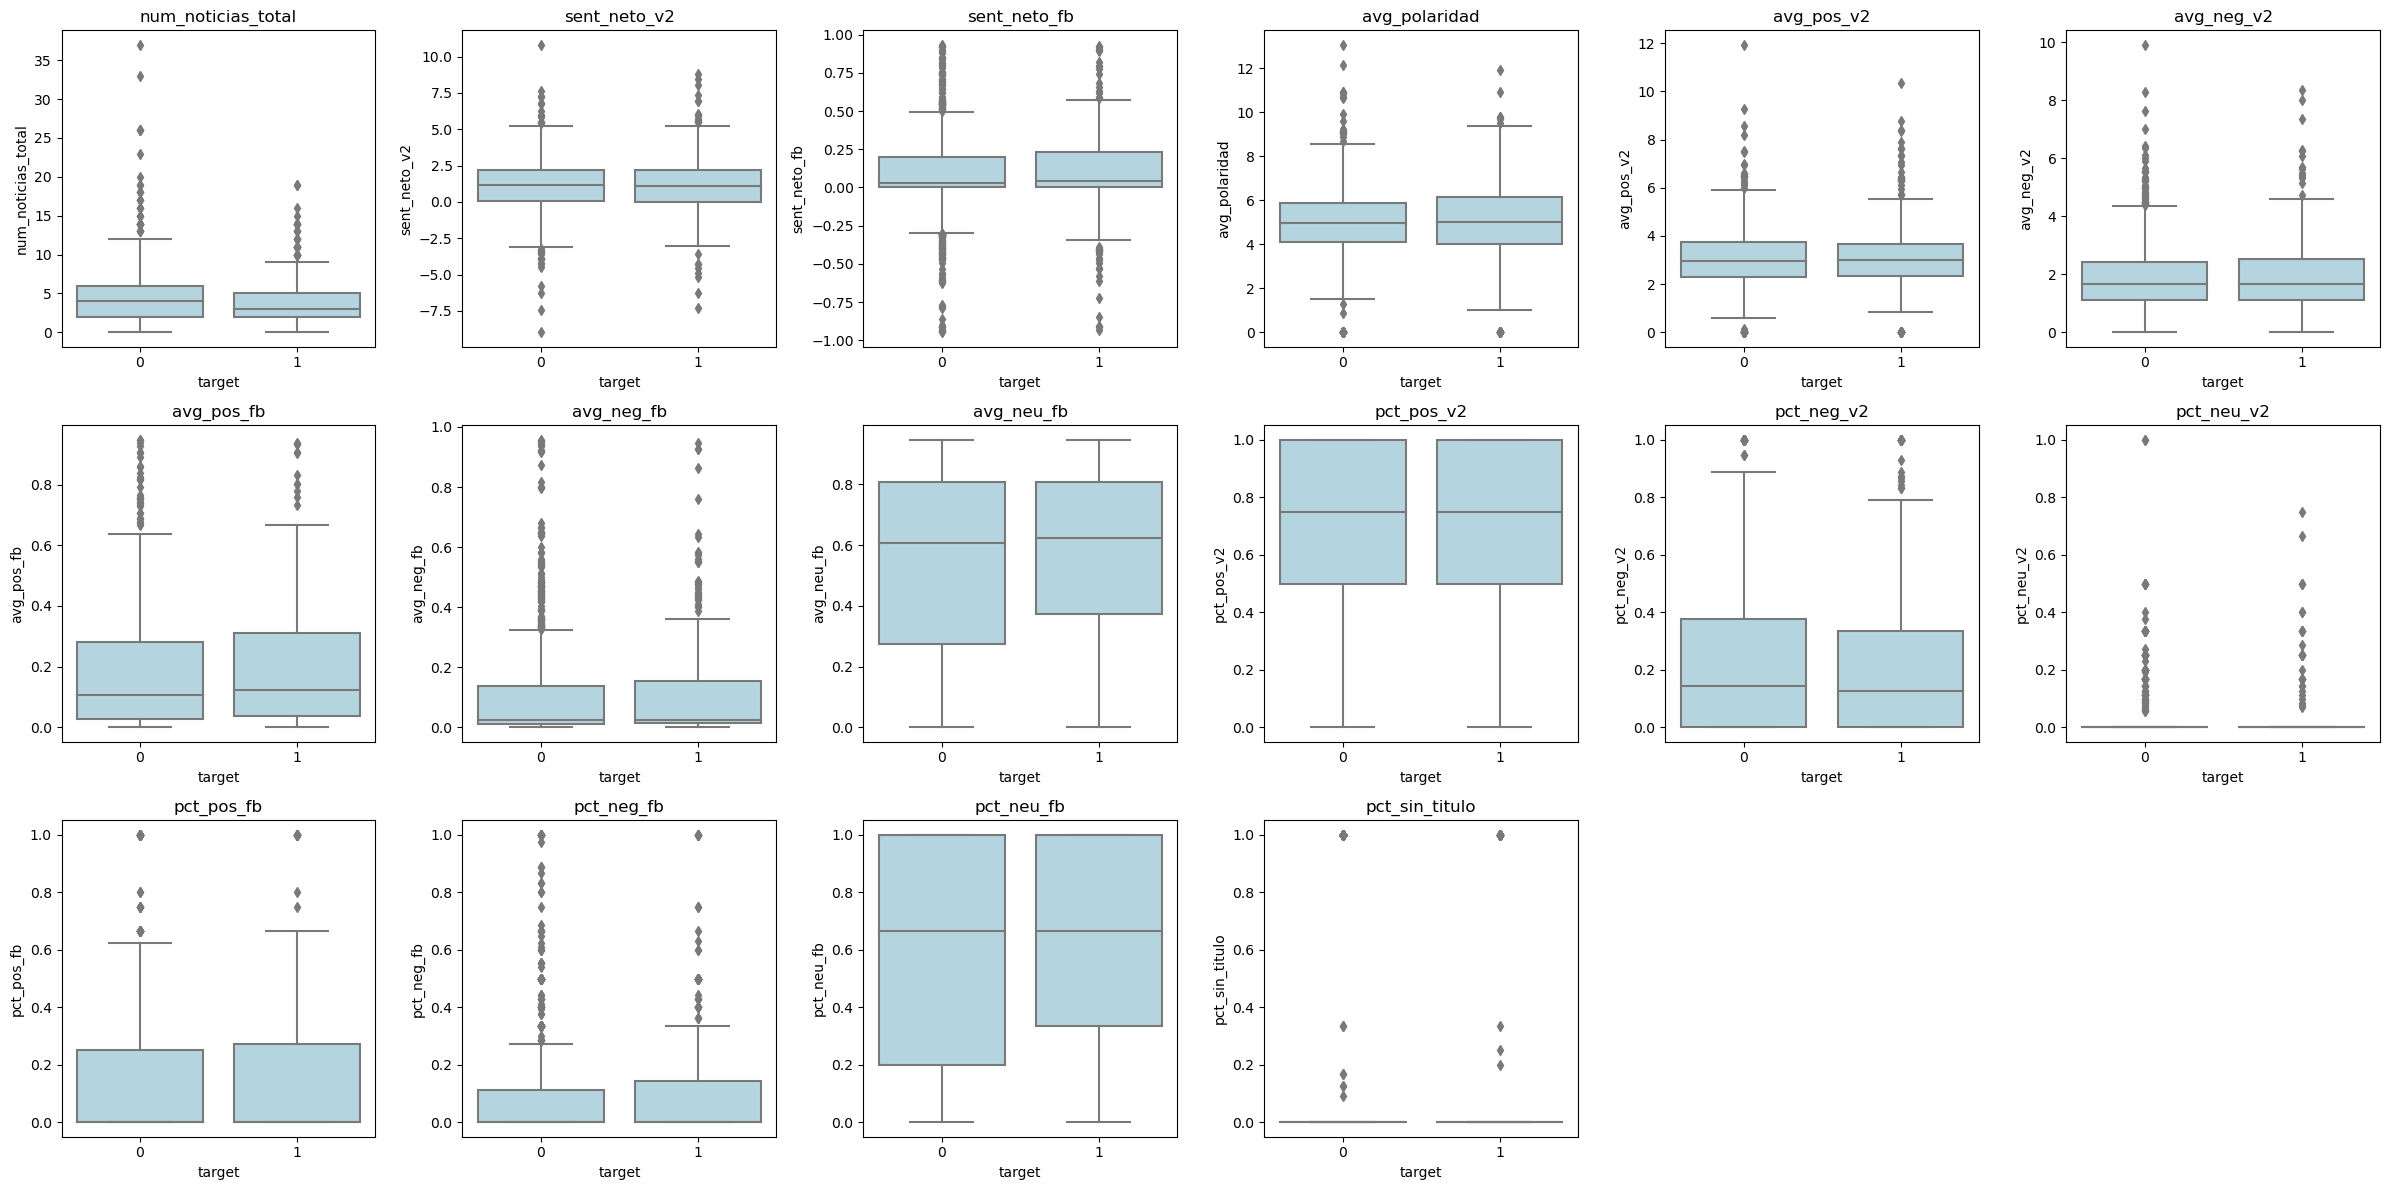

In [19]:
plot_boxplots(datos_noticias, vars_agregados)

## Variables ratio y delta:
Identificar si la media de sentimiento por día cambia en función del target

In [20]:
vars_ratio = [var for var in datos_noticias.columns if var.startswith("ratio")]
vars_delta = ['delta_sent_neto_v2', 'delta_sent_neto_fb', 'delta_num_noticias']
vars_diff = ['diff_sent_fb_v2', 'diff_pct_pos_fb_v2', 'diff_pct_neg_fb_v2']

vars_ratio_delta = vars_ratio + vars_delta + vars_diff

<AxesSubplot:>

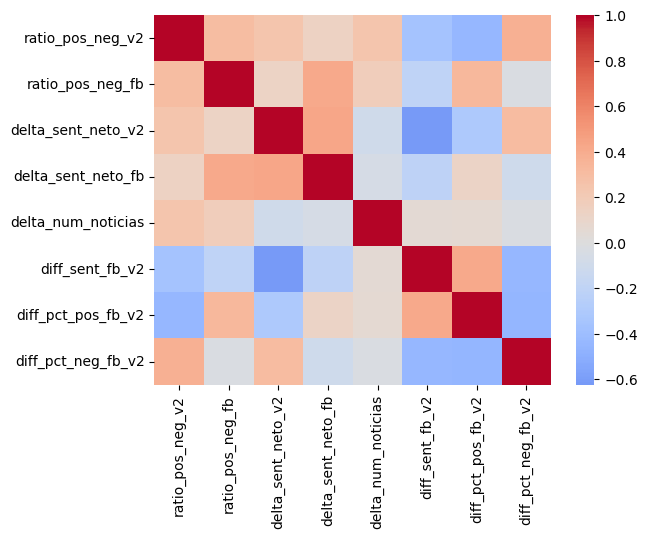

In [21]:
df_corr = datos_noticias.toPandas()
sns.heatmap(df_corr[vars_ratio_delta].corr(), cmap="coolwarm", center=0)

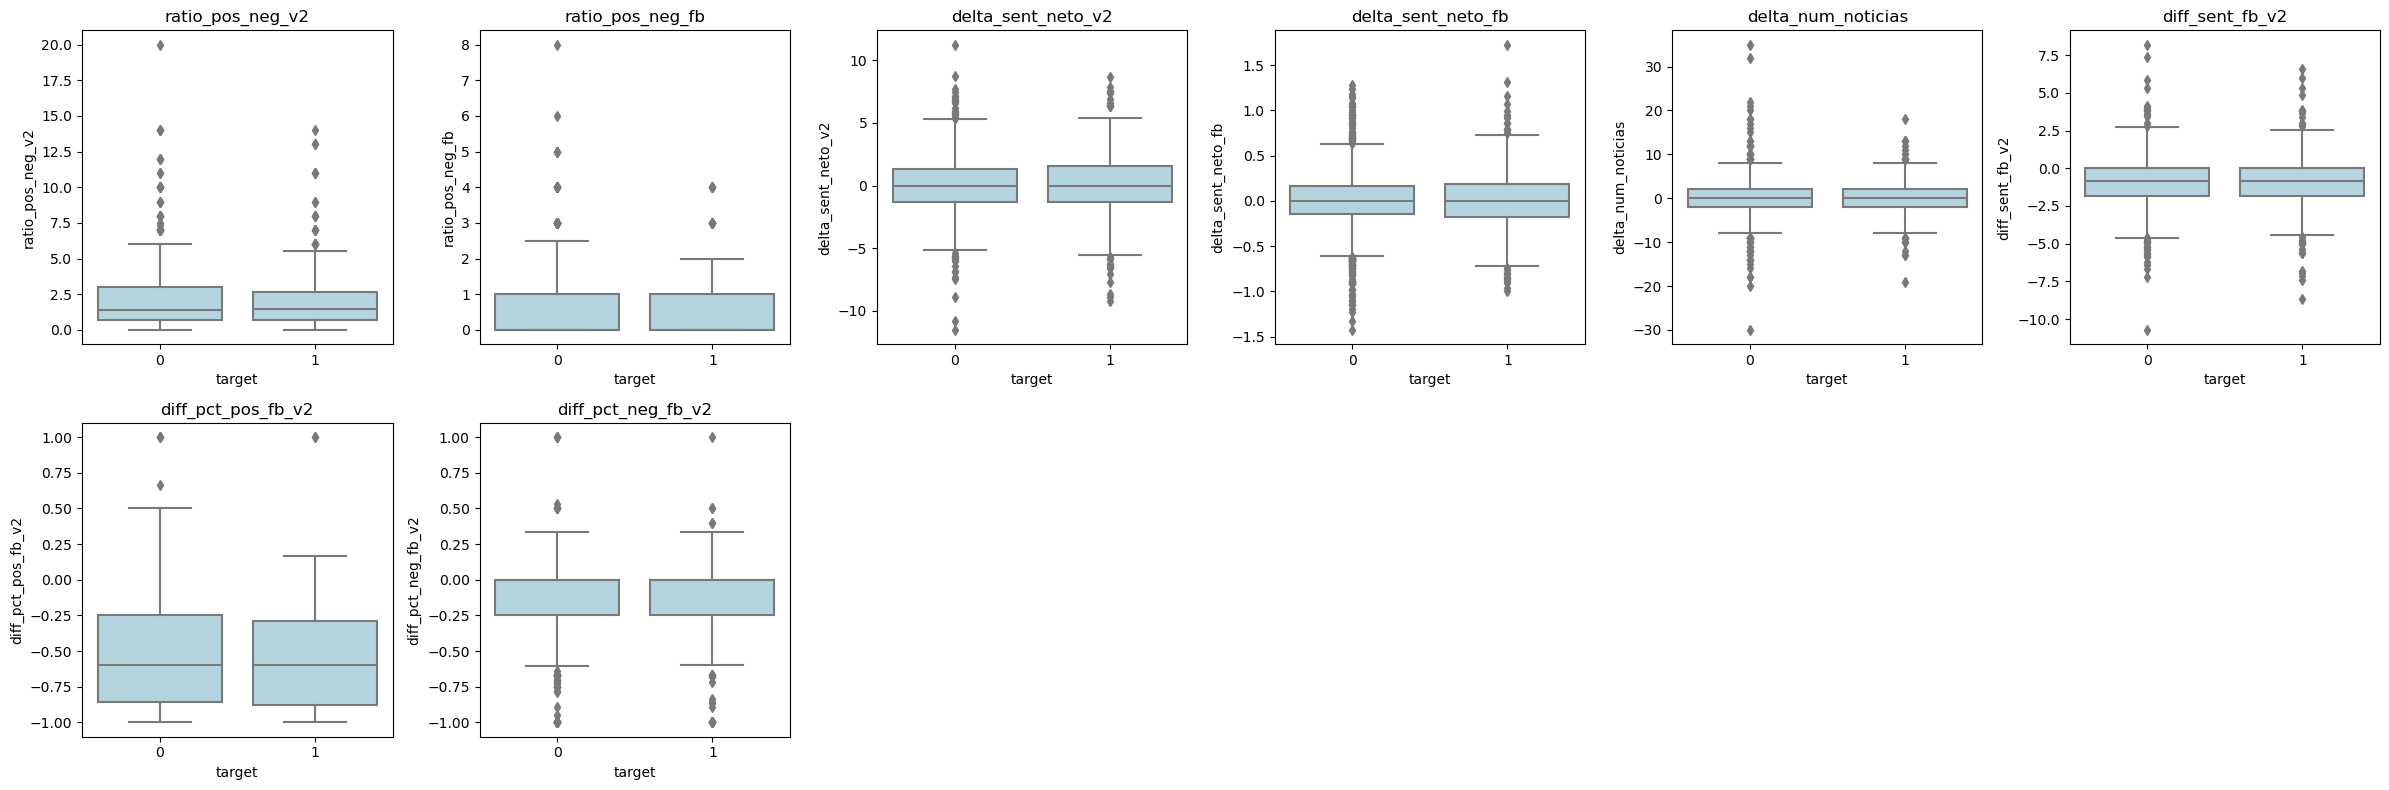

In [22]:
plot_boxplots(datos_noticias, vars_ratio_delta)

## Indicadores de tendencia y ventanas móviles:
Estas variables resumen la fuerza y dirección del sentimiento

In [23]:
vars_vm = [var for var in datos_noticias.columns if var.endswith("d") and (var != "avg_polaridad")]
vars_interacciones = ["sent_neto_fb_x_num_noticias", "sent_neto_v2_x_num_noticias", "avg_pos_x_neg_fb", "avg_pos_x_neg_v2", "delta_sent_x_sent_neto_fb","delta_sent_x_sent_neto_v2"]

vars_indicadores = vars_vm + vars_interacciones

<AxesSubplot:>

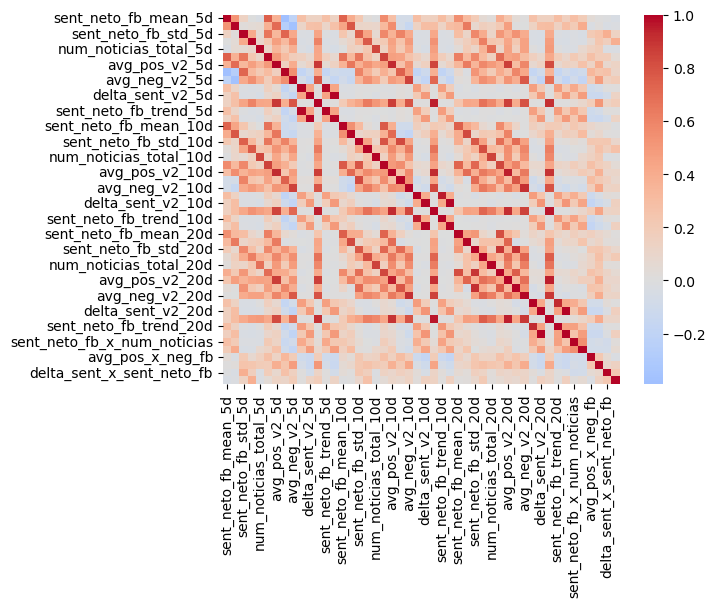

In [24]:
df_corr = datos_noticias.toPandas()
sns.heatmap(df_corr[vars_indicadores].corr(), cmap="coolwarm", center=0)

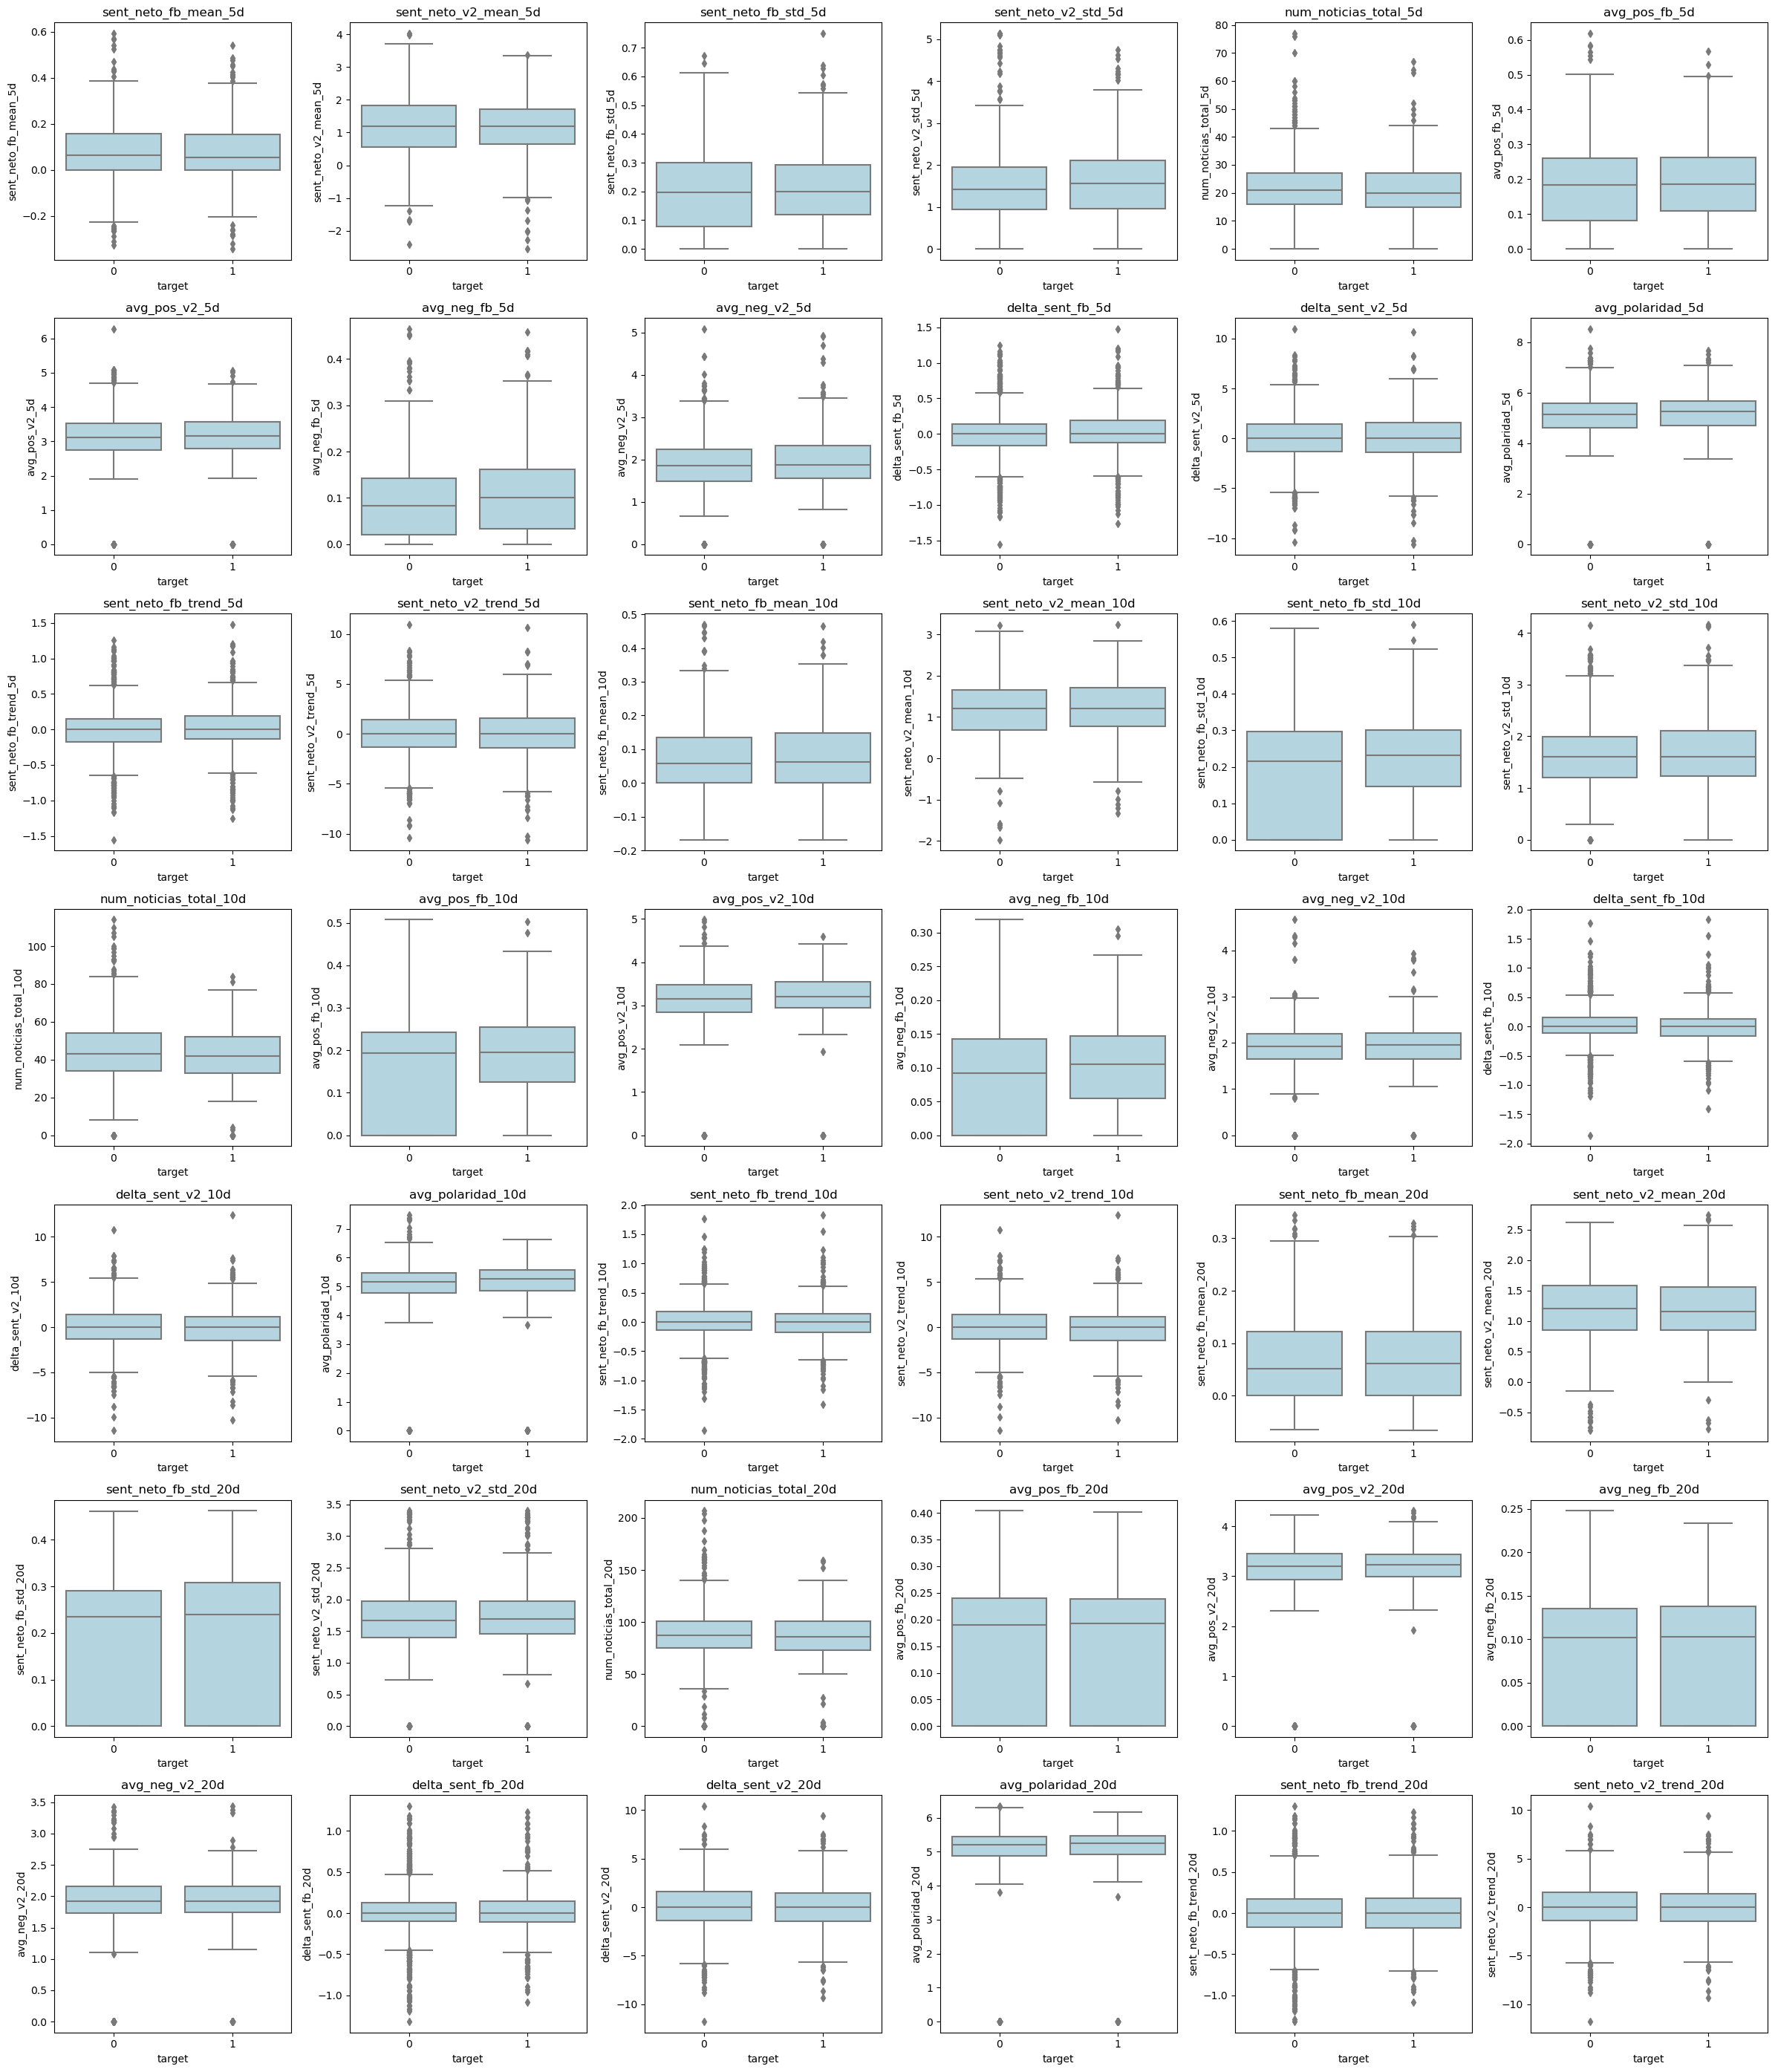

In [25]:
plot_boxplots(datos_noticias, vars_vm)

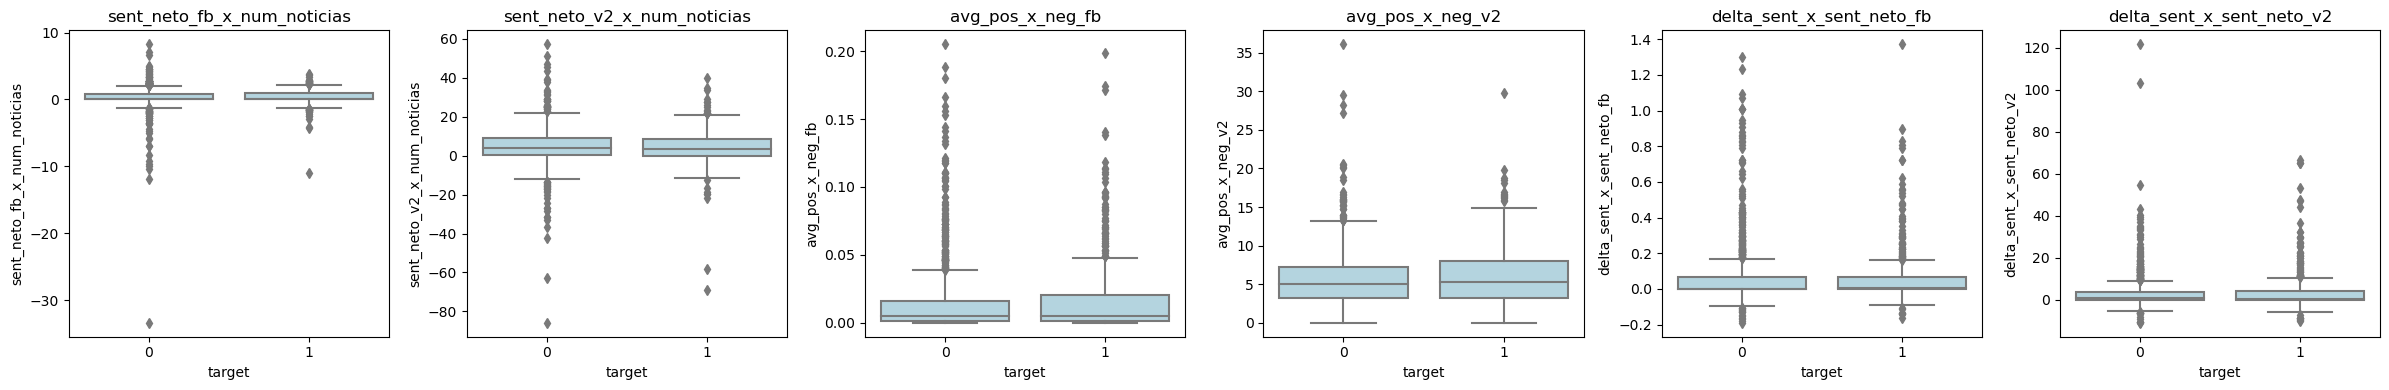

In [26]:
plot_boxplots(datos_noticias, vars_interacciones)

# Output

In [27]:
datos_noticias.write.mode("overwrite").format("parquet").save(f"{path_datos}/{output_name}")

In [28]:
datos_noticias.columns

['date',
 'target',
 'num_noticias_total',
 'avg_polaridad',
 'avg_pos_v2',
 'avg_neg_v2',
 'avg_pos_fb',
 'avg_neg_fb',
 'avg_neu_fb',
 'sent_neto_v2',
 'sent_neto_fb',
 'pct_pos_v2',
 'pct_neg_v2',
 'pct_neu_v2',
 'pct_pos_fb',
 'pct_neg_fb',
 'pct_neu_fb',
 'pct_sin_titulo',
 'ratio_pos_neg_v2',
 'ratio_pos_neg_fb',
 'diff_sent_fb_v2',
 'diff_pct_pos_fb_v2',
 'diff_pct_neg_fb_v2',
 'delta_sent_neto_v2',
 'delta_sent_neto_fb',
 'delta_num_noticias',
 'sent_neto_fb_mean_5d',
 'sent_neto_v2_mean_5d',
 'sent_neto_fb_std_5d',
 'sent_neto_v2_std_5d',
 'num_noticias_total_5d',
 'avg_pos_fb_5d',
 'avg_pos_v2_5d',
 'avg_neg_fb_5d',
 'avg_neg_v2_5d',
 'delta_sent_fb_5d',
 'delta_sent_v2_5d',
 'avg_polaridad_5d',
 'sent_neto_fb_trend_5d',
 'sent_neto_v2_trend_5d',
 'sent_neto_fb_mean_10d',
 'sent_neto_v2_mean_10d',
 'sent_neto_fb_std_10d',
 'sent_neto_v2_std_10d',
 'num_noticias_total_10d',
 'avg_pos_fb_10d',
 'avg_pos_v2_10d',
 'avg_neg_fb_10d',
 'avg_neg_v2_10d',
 'delta_sent_fb_10d',
 'delt